In [1]:
import numpy as np

class Waves:
    def __init__(self, pos, dims, f, wave_length, direction, thresh):

        self.dims = dims
        self.x = np.linspace(-self.dims[1]/2.0, self.dims[1]/2.0, self.dims[1])
        self.y = np.linspace(-self.dims[0]/2.0, self.dims[0]/2.0, self.dims[0])

        self.x_grid, self.y_grid = np.meshgrid(self.x, self.y)


        self.visualisation = np.ones((self.dims[0], self.dims[1]), np.float32)
        self.thresh = thresh
        self.f = f
        self.wave_length = wave_length
        self.pos = pos
        self.direction = direction # should be +/- 1
    
    def draw(self):
        cv2.imshow("decision_making", self.visualisation)
        cv2.waitKey(1) 

    def run(self):
        self.graphics()

    def close(self):
        #opencv on mac hack
        for i in range(5):

            cv2.destroyAllWindows()
            cv2.waitKey(1)
            
class StraightWaves(Waves):
    
    def __init__(self, pos, dims, f, theta, wave_length, direction, thresh):
        Waves.__init__(self, pos, dims, f, wave_length, direction, thresh)
        self.theta = theta
        
    def make_waves(self, t):

        x_part = self.x_grid * np.cos(self.theta)
        y_part = self.y_grid * np.sin(self.theta)
        total_part = x_part + y_part 
        self.visualisation = ((np.sin(np.pi*2 * (total_part / self.wave_length - 
                                                self.direction * self.f*t)) + 1.0) / 2.0)
        if self.thresh == True:
            self.visualisation = np.round(self.visualisation)

        return self.visualisation
            
class CircularWaves(Waves):
    
    def __init__(self, pos, dims, f, wave_length, direction, thresh):
        Waves.__init__(self, pos, dims, f, wave_length, direction, thresh)
        
    def make_waves(self, t):

        theta = atan2(self.x_grid, self.y_grid) 
        self.visualisation = (
            (np.sin(np.pi*2 * (theta/self.wave_length - self.direction*self.f*t))+ 1.0) 
                / 2.0)
        if self.thresh == True:
            self.visualisation = np.round(self.visualisation)

        return self.visualisation

class Environment:
    def __init__(self, dims):
        self.dims = dims
        self.background_value = 0.0
        self.visualisation = (np.zeros((self.dims[0], self.dims[1]), np.float32) *
                              self.background_value)
        self.features = []
        self.num_features = 0

    #Feature should be a size (dim, n)    
    def add_feature(self, feature):
        if isinstance(feature, (list,tuple)):
            for f in feature:
                self.features.append(f)
                self.num_features += 1
        else:
            self.features.append(feature)
            self.num_features += 1

    def get_matrix(self, t):

        for feature in self.features:
            self.visualisation[feature.pos[0]:(feature.pos[0] + feature.dims[0]),
                               feature.pos[1]:(feature.pos[1] + feature.dims[1])] = (
                feature.make_waves(t))
        #self.visualisation /= self.num_features
        return self.visualisation


    def draw(self, t):
        self.visualisation = self.get_matrix(t)
        cv2.imshow('the environment', self.visualisation)
        cv2.waitKey(1)

    def close(self):
        #opencv on mac hack
        for i in range(5):

            cv2.destroyAllWindows()
            cv2.waitKey(1)


In [2]:
%pylab inline

from __future__ import division
from __future__ import print_function

import os.path
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from tensorflow.python.client import timeline
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import json
#from group_perception_model import Waves_np, Environment_np 
from itertools import count

Populating the interactive namespace from numpy and matplotlib


In [3]:

def create_mask(r, inner_r, outer_r):
    """Return a mask that is true is distance is within the specified range
    
    arguments:
    r -- matrix containg distances between all individuals: shape() = (n,m)
    inner_r -- minimum distance (exclusive)
    outer_r -- maximum distance (exclusive)
    
    return matrix shape = (n,m,2)
    """
    mask = tf.logical_and(tf.less(abs_r, outer_r), tf.greater(abs_r, inner_r))
    mask = tf.cast(mask, tf.float32)
    mask = tf.expand_dims(mask, 2)
    mask = tf.tile(mask,(1,1,2))
    mask = tf.cast(mask, tf.bool)
    return(mask)

def zone_vec_v(expanded_val, mask, num_particles, zero_matrix):
    """Apply mask to velocities calculate social alignment
    """
    vals = tf.tile(expanded_val, [1, num_particles, 1])
    #take term from vals where mask is true and from zeros when false
    vals = tf.where(mask, vals, zero_matrix)
    return(tf.reduce_sum(vals, 0))

def zone_vec_x(rel_pos, mask, zero_matrix):
    #take term from rel_pos where mask is true and from zeros when false
    vals = tf.where(mask, rel_pos, zero_matrix)
    return(tf.reduce_sum(vals, 0))

In [4]:
def atan2(y, x, epsilon=1.0e-12):
    # Add a small number to all zeros, to avoid division by zero:
    x = tf.where(tf.equal(x, 0.0), x+epsilon, x)
    y = tf.where(tf.equal(y, 0.0), y+epsilon, y)

    angle = tf.where(tf.greater(x,0.0), tf.atan(y/x), tf.zeros_like(x))
    angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.greater_equal(y,0.0)), tf.atan(y/x) + np.pi, angle)
    angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.less(y,0.0)), tf.atan(y/x) - np.pi, angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.greater(y,0.0)), 0.5*np.pi * tf.ones_like(x), angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.less(y,0.0)), -0.5*np.pi * tf.ones_like(x), angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.equal(y,0.0)), tf.zeros_like(x), angle)
    return angle

In [5]:
def read_and_decode_single_example(filename, example_size):
    # first construct a queue containing a list of filenames.
    # this lets a user split up there dataset in multiple files to keep
    # size down
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None,
                                                    shuffle = False,
                                                    capacity = 32)
    # Unlike the TFRecordWriter, the TFRecordReader is symbolic
    reader = tf.TFRecordReader(
        options=tf.python_io.TFRecordOptions(
            tf.python_io.TFRecordCompressionType.NONE))
    # One can read a single serialized example from a filename
    # serialized_example is a Tensor of type string.
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([example_size], tf.float32)
        })
    # now return the converted data
    label = features['label']
    image = features['image']
    return label, image

In [6]:
def simple_read_and_decode(filename):
    reader = tf.TFRecordReader()
    _, queue_batch = reader.read_up_to(filename, 100)
    return queue_batch

In [7]:
#------------------------------INPUT PARAMETERS-----------------------------------------------------------------
tf.reset_default_graph()
PeriodicBoundary = True   
CELL_SIZE = 1000.0                  # Sets the range of the "simulation world" coordinates
DT = tf.constant(.25, tf.float32)   # Time step: time lapse of molecular dynamic simulation step  #was 0.00005
m = tf.constant(0.5, tf.float32)    # mass of particles
NUM_PARTICLES = 500                # Number of particles to generate
SOCIAL_WEIGHT = 0.3                 # Weighting of social vector vs previous velocity vector
NOISE_STD_DIV = 0.0
BODY_SIZE = 2.5
ARENA_SIZE = 1000

np.random.seed(190)
init_positions = np.random.rand(NUM_PARTICLES, 2) * 3 * CELL_SIZE / 4 + CELL_SIZE / 8    # initial position of particles
init_velocities = (np.random.standard_normal(size = (NUM_PARTICLES, 2)))       # initial velocities of particles

# make all velocities unit vectors
init_velocities_mag = np.square(init_velocities)
init_velocities_mag = np.sum(init_velocities_mag, 1)  
init_velocities_mag = np.expand_dims(init_velocities_mag, 1)
init_velocities_mag = np.tile(init_velocities_mag, (1, 2))
init_velocities_mag = np.sqrt(init_velocities_mag)
init_velocities = init_velocities / init_velocities_mag


In [8]:
random_int_array = np.random.choice([0,1], (NUM_PARTICLES, 1000))
random_noise_array = np.random.normal(0, NOISE_STD_DIV, (NUM_PARTICLES, 1000))

In [9]:
#Make background stimuli
number_of_frames = 200

# create the background environment

w1 = StraightWaves((0,0), (ARENA_SIZE, int(ARENA_SIZE)), 0.5, -np.pi/2, 201, -1, False)
w2 = CircularWaves((0,0), (ARENA_SIZE, int(ARENA_SIZE/2)), 0.6, np.pi/6, -1, False)
w3 = StraightWaves((0,int(ARENA_SIZE/2)), (ARENA_SIZE, int(ARENA_SIZE/2)), 0.5, -np.pi/2, 201, 1, False)
w4 = CircularWaves((0,0), (ARENA_SIZE, int(ARENA_SIZE/2)), 0.3, np.pi/24, 1, False)
waves1 = [w3]
waves = [w1, w3]

waves3 = [w3, w1]

sobel_x = np.array([[1,2,0,-2,-1],[4,8,0,-8,-4],[6,12,0,-12,-6],[4,8,0,-8,-4],[1,2,0,-2,-1]],np.float32)
sobel_y = np.transpose(sobel_x)
sobel_filter_feed = np.stack([sobel_x, sobel_y], 2)
sobel_filter_feed = np.expand_dims(sobel_filter_feed, 2)


env = Environment((ARENA_SIZE, ARENA_SIZE))
env.add_feature(waves)
env1 = Environment((ARENA_SIZE, ARENA_SIZE))
env1.add_feature(waves1)

'''
for indx in range(100):
    frame = (env.get_matrix(2*np.pi*indx /number_of_frames *33))
    cv2.imshow('test', frame)
    cv2.waitKey(1)
'''    
cv2.destroyAllWindows()

file_name = "reverse_gratings_None.tfrecords"

if os.path.isfile(file_name):
    print('pre-loaded background')
else:
    background_stimuli = np.zeros(( number_of_frames, ARENA_SIZE, ARENA_SIZE))
    for frame_num in range(number_of_frames):
        background_stimuli[frame_num, :, :] = (env.get_matrix(2*np.pi*frame_num / 
                                                              number_of_frames))
       
        if frame_num % 100 == 0:
            print(frame_num)
    compression = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
    writer = tf.python_io.TFRecordWriter(file_name, compression)
    # iterate over each example

    for example_indx in range(background_stimuli.shape[0]):
        
        if example_indx == 0:
            features = np.concatenate(
                (np.expand_dims(background_stimuli[-1, :, :], 0), 
                 background_stimuli[example_indx:example_indx + 2, :, :]), 0
            )
        elif example_indx == background_stimuli.shape[0] - 1:
            features = np.concatenate(
                (background_stimuli[example_indx-1:example_indx + 1, :, :], 
                 np.expand_dims(background_stimuli[0, :, :], 0)), 0
            )
        else:
            features = background_stimuli[example_indx - 1:example_indx + 2, :, :]
        
        #features = background_stimuli[example_indx, :, :]
        features = np.reshape(features, [-1])
        label = example_indx

        # construct the Example proto object
        example = tf.train.Example(
            # Example contains a Features proto object
            features=tf.train.Features(
              # Features contains a map of string to Feature proto objects
              feature={
                # A Feature contains one of either a int64_list,
                # float_list, or bytes_list
                'image': tf.train.Feature(
                    float_list=tf.train.FloatList(value=features.astype(float))),
                'label': tf.train.Feature(
                    int64_list=tf.train.Int64List(value=[label])),        
        }))
        # use the proto object to serialize the example to a string
        serialized = example.SerializeToString()
        # write the serialized object to disk
        writer.write(serialized)
    writer.close()
    print('successfully created and saved background')
    
    

0
100
successfully created and saved background


In [10]:
def get_image_batch(file_name, batch_size, image_size):
    filename_queue = tf.train.string_input_producer([file_name],
                                                    num_epochs=None,
                                                    shuffle = False,
                                                    capacity = 32)
    reader = tf.TFRecordReader()
    _, queue_batch = reader.read_up_to(filename_queue, batch_size)
    batch_serialized = tf.train.batch([queue_batch], batch_size=batch_size,
                                      num_threads=10, capacity=60000,
                                     enqueue_many=True)

    features = tf.parse_example(
        batch_serialized,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([image_size], tf.float32)
        })
    return features['image']

In [11]:
#---------------------Placeholders input parametes for the graph---------------------------------------------
x = tf.placeholder(dtype=tf.float32)   # Position of particles in the begining of simulation step (input)
v = tf.placeholder(dtype=tf.float32)   # Velocities of particles  in the begining of simulation step (input)
sobel_filter = tf.placeholder(dtype=tf.float32) #sobel filter
frame_number = tf.placeholder(dtype=tf.int32)

#e_past = tf.placeholder(dtype=tf.float32) 
#e_present = tf.placeholder(dtype=tf.float32) 
#e_future = tf.placeholder(dtype=tf.float32)


# returns symbolic label and image
image_size = 3 * ARENA_SIZE * ARENA_SIZE 
label, image = read_and_decode_single_example(file_name, image_size)
#label_batch, image_batch = tf.train.batch([image, label], batch_size=100,
#                                          num_threads=20, capacity=60000)
'''
batch_size = 100
image_size = 3 * ARENA_SIZE * ARENA_SIZE 


image_batch = get_image_batch(file_name, batch_size, image_size)

if frame_number % batch_size == 0: 
    image_batch = get_image_batch(file_name, batch_size, image_size)

#figure out how to slice the image_batch to just get one image -> what is image_batch.shape?
    
image = tf.slice(image_batch, [frame_number, 0], [1, -1] )

image = tf.squeeze(image)

#if frame_number % BATCH_SIZE == 0:
#label, image = read_and_decode_single_example(file_name, 3 * ARENA_SIZE * ARENA_SIZE)
#    tf.train_batch([image, label], batch_size = 128, capacity = 2000)
'''   
image = tf.reshape(image, (3, ARENA_SIZE, ARENA_SIZE))

e_past, e_present, e_future = tf.split(image, 3, 0)
e_past = tf.squeeze(e_past)
e_present = tf.squeeze(e_present)
e_future = tf.squeeze(e_future)
#e_past = tf.cast(e_past, tf.float32) / 255.0
#e_present = tf.cast(e_present, tf.float32) / 255.0
#e_future = tf.cast(e_future, tf.float32) / 255.0

environment = tf.placeholder(dtype=tf.float32)
max_frame = tf.constant(number_of_frames)

#***************Create the graph to simulate single molecular dynamic (m.d) simulation step---------------------------------------------------------------------------------------------------

expanded_x1 = tf.expand_dims(x, 0, name='expanded_x1')  
expanded_v1 = tf.expand_dims(v, 0, name='expanded_v1')

#normalize v1. This will happen at every step in the simulation

expanded_v12 = tf.square(expanded_v1)
expanded_v12_mag = tf.reduce_sum(expanded_v12, 1)
expanded_v1_mag = tf.sqrt(expanded_v12)
expanded_v1_norm = expanded_v1 / expanded_v1_mag    

In [12]:
#e_past, e_present, e_future = tf.split(e, 3, 2)
#e_present = tf.squeeze(e_present)
#TIME_SCALE = .1
#e_past = tf.slice(environment, (0, 0, frame_number - 1), (-1, -1, 1))
#e_past = tf.squeeze(e_past)
#e_present = tf.slice(environment, (0, 0, frame_number), (-1, -1, 1))
#e_present = tf.squeeze(e_present)
#if frame_number == max_frame - 1:
#    e_future = tf.slice(environment, (0, 0, 0), (-1, -1, 1))
#else:
#    e_future = tf.slice(environment, (0, 0, frame_number + 1), (-1, -1, 1))
#e_future = tf.squeeze(e_future)

#e_past = tf.ones((ARENA_SIZE, ARENA_SIZE))
#e_present = tf.ones_like(e_past)
#e_future = tf.ones_like(e_past)

if PeriodicBoundary: 
    CellPos = [] #Will hold all the neighboring cells 
    for i in range(-1, 2): #Iterates over3 the neighboring cells
        for i2 in range(-1, 2):
            CellPos.append([i*CELL_SIZE, i2*CELL_SIZE]) # (0,0) position of each of the neighbouring cells (top left corner)
    AllParticles = tf.expand_dims(CellPos, 1)  + expanded_x1  #Add particle position info to the neighbor cells
    AllParticles = tf.reshape(AllParticles,[-1, 2]) # Reshape to single array of particles coordinates
    expanded_x2 = tf.expand_dims(AllParticles, 1)
    AllParticlesV = tf.tile(expanded_v1_norm, [1, 9, 1])
    AllParticlesV = tf.reshape(AllParticlesV,[-1, 2])
    expanded_v2 = tf.expand_dims(AllParticlesV, 1)
    
    e_expanded = tf.tile(e_present, (3,3))
    e_expanded = tf.expand_dims(e_expanded, 0, name='expanded_e1')
    e_expanded = tf.expand_dims(e_expanded, 3, name='expanded_e2')
    
else:
    expanded_x2 = tf.expand_dims(x, 1, name='expanded')
    expanded_v2 = tf.expand_dims(v, 1, name='expanded')
    
    e_expanded = tf.expand_dims(e_present, 0, name='expanded')
    e_expanded = tf.expand_dims(e_expanded, 3, name='expanded')

In [13]:
#calculate environmental gradients

grad = tf.nn.conv2d(e_expanded, sobel_filter, [1,1,1,1], "SAME")
grad = tf.squeeze(grad)

if PeriodicBoundary:
    grad = tf.slice(grad, (ARENA_SIZE, ARENA_SIZE, 0), (ARENA_SIZE, ARENA_SIZE, -1)) 

grad_t = e_future * 96 - e_past * 96 
grad_t = tf.squeeze(grad_t)
    
personal_information_weight = tf.constant(.5)

In [14]:
rx=tf.subtract(expanded_x1,expanded_x2 )#Distance between every pair of particles in x in every dimension (dx,dy)
rx2=tf.square(rx) # sqar distane for each particle pair in each dimension  (dx^2,dx^2)
r2=tf.reduce_sum(rx2,2) # absolute squar distance between every pair of particles(dx^2+dx^2)
r=tf.sqrt(r2) # absolute distance between every pair of particles
r=tf.maximum(r,tf.ones_like(r)*0.0002)# To avoid division by zero make min distance larger then 0 this add to prevent simulation explosion if particles get too closed

abs_r = tf.abs(r)

zor_r = tf.constant(10.0 * BODY_SIZE, dtype = tf.float32 ) # radius of zone of alignment
zoo_r = tf.constant(30.0 * BODY_SIZE, dtype = tf.float32) # radius of zone of alignment
zoa_r = tf.constant(100.0 * BODY_SIZE, dtype = tf.float32) # radius of zone of alignment

zor_mask = create_mask(abs_r, 0.0, zor_r)
zoo_mask = create_mask(abs_r, zor_r, zoo_r)
zoa_mask = create_mask(abs_r, zoo_r, zoa_r)

if PeriodicBoundary:
    zero_matrix = tf.zeros([NUM_PARTICLES * 9, NUM_PARTICLES, 2], tf.float32)
else:
    zero_matrix = tf.zeros([NUM_PARTICLES, NUM_PARTICLES, 2], tf.float32)

r_expanded = tf.expand_dims(r, 2, name='expanded')
r_expanded = tf.tile(r_expanded, (1, 1, 2))
r_unit = rx / r_expanded
    
zor_x = zone_vec_x(r_unit, zor_mask, zero_matrix)
zoo_v = zone_vec_v(expanded_v2, zoo_mask, NUM_PARTICLES, zero_matrix)
zoa_x = zone_vec_x(r_unit, zoa_mask, zero_matrix)

zor_x = tf.multiply(zor_x, tf.constant(1.0))
zoo_v = tf.multiply(zoo_v, tf.constant(3.0))
zoa_x = tf.multiply(zoa_x, tf.constant(-0.5))

zor_sum = tf.reduce_sum(tf.abs(zor_x), 1)
mask_zor_empty = tf.logical_not(tf.greater(zor_sum, tf.constant(0.0)))

zoa_zoo = tf.multiply(tf.reduce_sum(zoa_x, 1), tf.reduce_sum(zoo_v,1))
mask_both_zones = tf.greater(zoa_zoo, tf.constant(0.0))
both_zones = tf.to_float(mask_both_zones)  #should be 0 if only one zone has individs, 1 if both
both_zones_expanded = tf.expand_dims(both_zones, 1, name='expanded')
both_zones_expanded = tf.tile(both_zones_expanded, (1,2))

outer_zones_v = tf.to_float(tf.pow(.5, both_zones_expanded)) * (zoa_x + zoo_v) 

vnew = tf.where(mask_zor_empty, outer_zones_v, zor_x)

vnew = tf.minimum(vnew, tf.ones_like(vnew) * 100000.0) #so speed can't blow up

personal_weight = 1 - SOCIAL_WEIGHT
vnew = SOCIAL_WEIGHT*vnew + personal_weight*init_velocities

vnew = vnew # + random_noise

tf.assert_rank(vnew, 2)

#Adding the environmental term
x_int = tf.cast(x, tf.int32)  #check how long this takes

x_int_x, x_int_y = tf.split(x_int, 2, 1)
m_int = x_int_x
n_int =x_int_y 
x_int_nm = tf.stack([n_int, m_int], 1)
x_int_nm = tf.squeeze(x_int_nm)

local_grad = tf.gather_nd(grad, x_int_nm)
local_grad_x = tf.slice(local_grad,(0,0),(-1,1))
local_grad_y = tf.slice(local_grad,(0,1),(-1,1))
local_grad_t = tf.gather_nd(grad_t, x_int_nm)
local_grad_t = tf.expand_dims(local_grad_t, 1)

v_x, v_y = tf.split(v, 2, 1)
vnew_x, vnew_y = tf.split(vnew, 2, 1)

norm_2 = local_grad_x * local_grad_x + local_grad_y * local_grad_y
norm_2 = tf.maximum(norm_2, 0.00001)

vnew = tf.stack([vnew_x, vnew_y], 1)
vnew = tf.squeeze(vnew)

tf.assert_rank(vnew, 2)


optic_x = -local_grad_t * local_grad_x / norm_2
optic_y = -local_grad_t * local_grad_y / norm_2

optic_v = tf.stack([optic_x, optic_y], 1)
optic_v = tf.squeeze(optic_v)

#Below this threshold just set the vector to 0
mag_thresh = 0.0001

#Normalize the optic flow vector
optic_v_mag = tf.square(optic_v)
optic_v_mag = tf.reduce_sum(optic_v_mag, 1) 
optic_v_mag = tf.sqrt(optic_v_mag)
optic_v_mag = tf.expand_dims(optic_v_mag, 1)
optic_v_mag = tf.tile(optic_v_mag, (1, 2)) 
optic_v = tf.where(optic_v_mag < mag_thresh, tf.zeros_like(optic_v), optic_v / optic_v_mag)

weight = .4
vnew = weight*optic_v + (1-weight)*vnew

#Normalize the final velocity
vnew_mag = tf.square(vnew)
vnew_mag = tf.reduce_sum(vnew_mag, 1) 
vnew_mag = tf.sqrt(vnew_mag)
vnew_mag = tf.expand_dims(vnew_mag, 1)
vnew_mag = tf.tile(vnew_mag, (1, 2)) 
vnew = tf.where(vnew_mag < mag_thresh, tf.zeros_like(vnew), vnew / vnew_mag)

xnew = x + vnew*DT*4.0
 
#-----------if epetitive  boundary conditions are used make sure particle poistion dont exceed cell size-------------------------------------------------------------------
if PeriodicBoundary:
    xnew=tf.mod(xnew + CELL_SIZE, CELL_SIZE)# repititive boundary conditions make sure the particle never exit the box
else:
    
    vnew_x, vnew_y = tf.split(vnew, 2, 1)
    xnew_x, xnew_y = tf.split(xnew, 2, 1)
    
    vnew_x = tf.where(xnew_x < 0.0, -vnew_x, vnew_x)
    vnew_x = tf.where(xnew_x >= CELL_SIZE - 1, -vnew_x, vnew_x)
    vnew_y = tf.where(xnew_y < 0.0, -vnew_y, vnew_y)
    vnew_y = tf.where(xnew_y >= CELL_SIZE - 1, -vnew_y, vnew_y)
    vnew = tf.stack([vnew_x, vnew_y], 1)
    vnew = tf.squeeze(vnew)
    
    xnew_x = tf.where(xnew_x < 0.0, tf.ones_like(xnew_x), xnew_x)
    xnew_x = tf.where(xnew_x >= CELL_SIZE - 1, 
                      tf.ones_like(xnew_x) * (CELL_SIZE - 2), xnew_x)
    xnew_y = tf.where(xnew_y < 0.0, tf.ones_like(xnew_y), xnew_y)
    xnew_y = tf.where(xnew_y >= CELL_SIZE - 1, 
                      tf.ones_like(xnew_y) * (CELL_SIZE - 2), xnew_y)
    xnew = tf.stack([xnew_x, xnew_y], 1)
    xnew = tf.squeeze(xnew)
    

    


In [15]:
#---------------------------Run the graph---------------------------------------------------------------------------

WITH_TIMER = False
SHOW_MOVING_BACKGROUND = True
SHOW_STILL_BACKGROUND = False
DRAW = False
VIDEO = True
'''
x1 = Waves_np((0,0), (1000,1000), .87, -np.pi/6, 17, 1, False)
#x2 = Waves((0,500), (1000, 500), .87, -np.pi/4, 17, 1, False)
#x3 = Waves((350,350), (350, 200), .35, np.pi/1, 40, 1, True)
x = [x1]

env_np = Environment_np((ARENA_SIZE, ARENA_SIZE))
env_np.add_feature(x)


#Make the static background image
vis1 = np.expand_dims(env_np.get_matrix(0), 2)
vis1 = np.tile(vis1, (1, 1, 3))
vis1 = vis1/3 + .66
vis1[:,:,1] = vis1[:,:,1]/2 + .5
vis2 = np.expand_dims(env_np.get_matrix(.4), 2)
vis2 = np.tile(vis2, (1, 1, 3))
vis2 = vis2/3 + .66
vis2[:,:,0] = vis2[:,:,0]/2 + .5
still_vis = .5 * (vis1 + vis2)
'''


with tf.Session() as session: #Create graph session
    
    init = tf.global_variables_initializer()
    session.run(init)
    coord = tf.train.Coordinator()
    
    tf.train.start_queue_runners(sess=session, coord=coord)
    
    time.sleep(10)
    
    if WITH_TIMER:
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        
    if VIDEO:
        print('simulating...')
        fourcc = cv2.VideoWriter_fourcc(*'avc1')
        out = cv2.VideoWriter(filename='output3.mp4', fourcc=fourcc, fps=30.0, 
                              frameSize=(ARENA_SIZE, ARENA_SIZE), isColor=True)

    time_start = time.time()
    for idx in range(5000):

        t0 = time.time()
        #env_past = background_stimuli[idx % number_of_frames - 1, :, :]
        #env_present = background_stimuli[idx % number_of_frames, :, :]
        #if idx % number_of_frames != number_of_frames - 1:
        #    env_future = background_stimuli[idx % number_of_frames + 1, :, :]
        #else:
        #    env_future = background_stimuli[0, :, :,0]
        dt0 = time.time() - t0
        t1 = time.time()

        if WITH_TIMER:

            [init_positions, init_velocities, background] \
                = session.run([xnew,vnew, e_present],
                            feed_dict={x: init_positions, 
                                       v: init_velocities,  
                                       sobel_filter: sobel_filter_feed,
                                       #e_past: env_past,
                                       #e_present: env_present,
                                       #e_future: env_future
                                       },
                            options=run_options, run_metadata=run_metadata)
            
            tl = timeline.Timeline(run_metadata.step_stats)
            ctf = tl.generate_chrome_trace_format()

            with open('timeline.json', 'w') as tl:
                tl.write(ctf)
        else:
            
            [init_positions, init_velocities, background] \
                = session.run([xnew, vnew, e_present],
                              feed_dict={x: init_positions, 
                                         v: init_velocities, 
                                         sobel_filter: sobel_filter_feed,
                                         frame_number: idx
                                         #e_past: env_past,
                                         #e_present: env_present,
                                         #e_future: env_future
                                        })

        dt1 = time.time() - t1
    #----------------------Plot particles position real time---------------------------------------------       
        if DRAW or VIDEO:    
            t2 = time.time()
            if (idx%2==0):
                #print(color/48.0)
                '''
                background = np.squeeze(grad_test)
                background = background[:,:,0]
                #print(background.min(), " ", background.max())
                background = ((background + np.abs(background.min())) / 
                              (2*max(background.max(), np.abs(background.min()))) * 1) 
                #print(background.min(), " ", background.max())
                color = np.squeeze(color)
                color = ((color + np.abs(background.min())) / 
                              (2*max(background.max(), np.abs(background.min()))) * 1).astype(int)
                '''

                
                if SHOW_MOVING_BACKGROUND:
                    #background = background[500:1500, 500:1500]
                    visualization = np.expand_dims(background, 2) * .2
                    visualization = np.tile(visualization, (1, 1, 3))
                elif SHOW_STILL_BACKGROUND:
                    visualization = np.copy(still_vis) 
                else:
                    visualization = np.ones((ARENA_SIZE, ARENA_SIZE, 3), np.uint8) * 200

                cord=(np.array(init_positions) * ARENA_SIZE / CELL_SIZE).astype(int) # Tranfer particles cordinates to numpy array format to use in plotting functin
                velocity = np.array(init_velocities)
                for indj in xrange(len(cord[:,0])):
                    cv2.circle(visualization,tuple(cord[indj,:]),
                               int(BODY_SIZE * ARENA_SIZE / CELL_SIZE),
                               (202,0,42), -1)
                    cv2.line(visualization,tuple(cord[indj,:]), 
                             tuple((cord[indj,:] - velocity[indj,:] * 3 * BODY_SIZE).astype(int)),
                             (202,0,42), 1, cv2.LINE_AA)
                if DRAW:
                    cv2.imshow("visualization", visualization)
                if VIDEO:
                    visualization = (visualization * 255.0).astype('u1')
                    #print(visualization.dtype)
                    out.write(visualization)
                    if idx % 100 == 0:
                        print('frame: %i' %(idx))
                dt = time.time() - t0
                #print(dt)
                if cv2.waitKey(1) & 0xFF == 27:
                    break  #time delay
            dt2 = time.time() - t2
        if idx % 10 == 0:    
            #print(dt0, " " , dt1, " ", dt2)
            continue
        if 0xFF == 27:
            break
    if VIDEO:
        out.release()
        print('finished')
    time_end = time_start - time.time()
    print(time_end)
    coord.request_stop()
    coord.join()
    session.close() 
cv2.destroyAllWindows()    
#nvidia-smi


simulating...
frame: 0
frame: 100
frame: 200
frame: 300
frame: 400
frame: 500
frame: 600
frame: 700
frame: 800
frame: 900
frame: 1000
frame: 1100
frame: 1200
frame: 1300
frame: 1400
frame: 1500
frame: 1600
frame: 1700
frame: 1800
frame: 1900
frame: 2000
frame: 2100
frame: 2200
frame: 2300
frame: 2400
frame: 2500
frame: 2600
frame: 2700
frame: 2800
frame: 2900
frame: 3000
frame: 3100
frame: 3200
frame: 3300
frame: 3400
frame: 3500
frame: 3600
frame: 3700
frame: 3800
frame: 3900
frame: 4000
frame: 4100
frame: 4200
frame: 4300
frame: 4400
frame: 4500
frame: 4600
frame: 4700
frame: 4800
frame: 4900
finished
-450.224408865


GZIP - 5000 frames, time = 600.9
ZLIB - 5000 frames, time = 496.7

In [ ]:
%pylab inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from group_perception_model import Waves, Environment 

session = tf.InteractiveSession()

ARENA_SIZE = 10

env = Environment((ARENA_SIZE, ARENA_SIZE))
x1 = Waves((0,0), (8,8), 3.1, -np.pi/4, 17, -1, False)
x2 = Waves((0,0), (6, 6), .37, np.pi/3, 20, 1, False)
x3 = Waves((1,1), (2, 2), .72, np.pi/1, 40, 1, False)
x = [x1, x2, x3]

env.add_feature(x)


NUM_PARTICLES = 10
CELL_SIZE = 10

sobel_x = np.array([[1,2,0,-2,-1],[4,8,0,-8,-4],[6,12,0,-12,-6],[4,8,0,-8,-4],[1,2,0,-2,-1]],np.float32)
sobel_y = np.transpose(sobel_x)
sobel_filter = np.stack([sobel_x, sobel_y], 2)
sobel_filter = np.expand_dims(sobel_filter, 2)

init_positions = (np.random.rand(NUM_PARTICLES, 2) * CELL_SIZE).astype(np.float32)
init_velocities = np.random.rand(NUM_PARTICLES, 2).astype(np.float32)

x = env.get_matrix(1)
x = tf.tile(x, (3,3))

x = tf.expand_dims(x, 0)
x = tf.expand_dims(x, 3)

x0 = env.get_matrix(.9)
x1 = env.get_matrix(1.1)


s_filter = tf.constant(sobel_filter)

grad = tf.nn.conv2d(x, s_filter, strides=[1,1,1,1], padding="SAME")
grad = tf.squeeze(grad)

grad_t = tf.subtract(x1, x0)

pos = tf.constant(init_positions, tf.int32)

res = tf.gather_nd(grad, pos)


x_int = tf.cast(init_positions, tf.int32)  #check how long this takes

local_grad = tf.gather_nd(grad, x_int)
local_grad_x, local_grad_y = tf.split(local_grad, 2, 1)



local_grad_t = tf.gather_nd(grad_t, x_int)
local_grad_t = tf.expand_dims(local_grad_t, 1)

vnew_x, vnew_y = tf.split(init_velocities, 2, 1)



u1 = -1.0 * (local_grad_y * vnew_y + local_grad_t) / local_grad_x
u2 = -1.0 * (local_grad_x * vnew_x + local_grad_t) / local_grad_y


vnew_u1 = tf.stack([u1, vnew_y], 1)
vnew_u2 = tf.stack([vnew_x, u2], 1)



random_positions = tf.random_uniform((NUM_PARTICLES, 1), minval=0, maxval=2, dtype=tf.int32)

random_test = tf.random((NUM_PARTICLES, 1), minval=0, maxval=2, dtype=tf.int32)


vnew = tf.where(random_positions == 0, vnew_u1, vnew_u2)

vnew = tf.squeeze(vnew)

rand_mag = .0000002
rand_vec = ((tf.ones_like(res)*-1)**
                 (tf.cast(tf.random_uniform(tf.shape(res), 0, 2, tf.int32),
                          tf.float32)))

vnew = tf.where(tf.abs(res) < rand_mag, rand_vec * rand_mag, vnew)
#print(res.eval())
#print(vnew.eval())

tf.assert_rank(vnew, 2)

vnew_mag = tf.square(vnew)
vnew_mag = tf.reduce_sum(vnew_mag, 1) 
vnew_mag = tf.sqrt(vnew_mag)
vnew_mag = tf.expand_dims(vnew_mag, 1)
vnew_mag = tf.tile(vnew_mag, (1, 2)) 
vnew = vnew / vnew_mag


rand1 = tf.random_uniform((NUM_PARTICLES,1), 0, 2, tf.int32)
rand2 = tf.random_uniform((NUM_PARTICLES,1), 0, 2, tf.int32)

random_positions = tf.stack([rand1, rand2], 1)
random_positions = tf.squeeze(random_positions)

print(vnew.eval())

print(vnew_u1.eval())
print(vnew_u2.eval())

#for i in xrange(1000):
#    env.draw(i/10.0)





In [19]:
env = Environment((ARENA_SIZE, ARENA_SIZE))
x1 = Waves((0,0), (8,8), 3.1, -np.pi/4, 17, -1, False)
x2 = Waves((0,0), (6, 6), .37, np.pi/3, 20, 1, False)
x3 = Waves((1,1), (2, 2), .72, np.pi/1, 40, 1, False)
x = [x1, x2, x3]

env.add_feature(x)

for i in xrange(100):
    t0 = time.time()
    for temp in xrange(3):
        background[:,:,temp] = env.get_matrix((i+temp-1)/10.0)
    print(time.time() - t0)

0.0170531272888
0.0155551433563
0.0152378082275
0.0148091316223
0.0143098831177
0.0140669345856
0.0137190818787
0.0133988857269
0.0128118991852
0.0123021602631
0.0120720863342
0.0113310813904
0.0110909938812
0.0157492160797
0.0125710964203
0.0108940601349
0.0106568336487
0.0106689929962
0.0106961727142
0.0106410980225
0.0106899738312
0.0106289386749
0.0105619430542
0.0106341838837
0.010635137558
0.0106389522552
0.0106210708618
0.0106530189514
0.0106391906738
0.0106520652771
0.0106580257416
0.0106410980225
0.0106580257416
0.010764837265
0.0108499526978
0.0106348991394
0.0108020305634
0.0106639862061
0.0106589794159
0.0107579231262
0.0106191635132
0.0106430053711
0.0106508731842
0.0106201171875
0.0106229782104
0.0106568336487
0.0106689929962
0.0106060504913
0.0106480121613
0.0106408596039
0.0107719898224
0.0106270313263
0.0106658935547
0.0108590126038
0.0106029510498
0.0106768608093
0.010617017746
0.0106239318848
0.0107429027557
0.0106229782104
0.0106539726257
0.0106000900269
0.010656118

Populating the interactive namespace from numpy and matplotlib


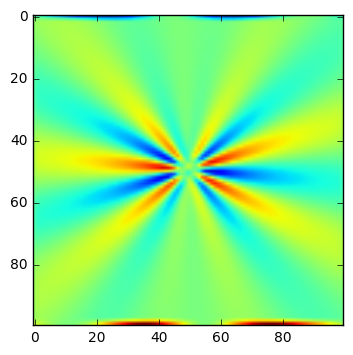

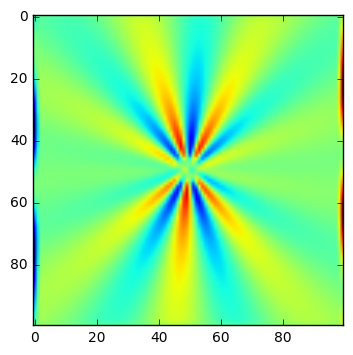

In [49]:
#calculate environmental gradients
%pylab inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

session = tf.InteractiveSession()

x1 = StraightWaves((100,100), .87, -np.pi/4, 17, -1, False)
x2 = CircularWaves((100,100), .87, np.pi/4, -1, False)

x = [x2]


env = Environment_tf((100, 100))
env.add_feature(x)

e = env.get_matrix(3)
e = tf.expand_dims(e, 0)
e = tf.expand_dims(e, 3)
sobel_x = tf.constant([[1,2,0,-2,-1],[4,8,0,-8,-4],[6,12,0,-12,-6],[4,8,0,-8,-4],[1,2,0,-2,-1]])
sobel_x = tf.cast(sobel_x, tf.float32)
sobel_y = tf.transpose(sobel_x)
sobel_filter = tf.stack([sobel_x, sobel_y], 2)
sobel_filter = tf.expand_dims(sobel_filter, 2)

grad = tf.nn.conv2d(e, sobel_filter, [1,1,1,1], "SAME")
grad = tf.squeeze(grad)

grad_x = tf.slice(grad,(0,0,0),(-1,-1,1))
grad_y = tf.slice(grad,(0,0,1),(-1,-1,1))

grad_x = tf.squeeze(grad_x)
grad_y = tf.squeeze(grad_y)

x = tf.random_uniform((10,2), dtype=tf.float32)*100.0

x_int = tf.cast(x, tf.int32)  #check how long this takes

local_grad = tf.gather_nd(grad, x_int)
local_grad_x = tf.slice(local_grad,(0,0),(-1,1))
local_grad_y = tf.slice(local_grad,(0,1),(-1,1))

grad_t = env.get_matrix(0) - env.get_matrix(0)
tf.assert_negative(grad_t)

grad_x_eval = grad_x.eval()
grad_y_eval = grad_y.eval()
plt.imshow(grad_y.eval())
plt.figure()
plt.imshow(grad_x.eval())
#print(local_grad_x.eval())
#print(local_grad_y.eval())
#print(grad_t.eval())


In [22]:
e = tf.ones([10,10])
e = tf.expand_dims(e, 0)
e = tf.expand_dims(e, 3)
sobel_x = np.array([[1,2,0,-2,-1],[4,8,0,-8,-4],[6,12,0,-12,-6],[4,8,0,-8,-4],[1,2,0,-2,-1]],np.float32)
sobel_y = np.transpose(sobel_x)
f = np.stack([sobel_x, sobel_y],2)
f = np.expand_dims(f,2)
f = tf.constant(f)
grad = tf.nn.conv2d(e, f,[1,1,1,1], "SAME")
grad = tf.squeeze(grad)


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from itertools import count
import cv2

class Waves_tf:
    def __init__(self, dims, f, wave_length, direction, thresh, pos=(0,0)):

        self.dims = dims
        self.x = tf.linspace(-self.dims[1]/2.0, self.dims[1]/2.0, self.dims[1])
        self.y = tf.linspace(-self.dims[0]/2.0, self.dims[0]/2.0, self.dims[0])

        self.x_grid, self.y_grid = tf.meshgrid(self.x, self.y)


        self.visualisation = tf.ones((self.dims[0], self.dims[1]), tf.float32)
        self.thresh = thresh
        self.f = f
        self.wave_length = wave_length
        self.pos = pos
        self.direction = direction # should be +/- 1
    
    def draw(self):
        cv2.imshow("decision_making", self.visualisation)
        cv2.waitKey(1) 

    def run(self):
        self.graphics()

    def close(self):
        #opencv on mac hack
        for i in range(5):

            cv2.destroyAllWindows()
            cv2.waitKey(1)
            
class StraightWaves(Waves_tf):
    
    def __init__(self, dims, f, theta, wave_length, direction, thresh):
        Waves_tf.__init__(self, dims, f, wave_length, direction, thresh)
        self.theta = theta
        
    def make_waves(self, t):

        x_part = self.x_grid * tf.cos(self.theta)
        y_part = self.y_grid * tf.sin(self.theta)
        total_part = x_part + y_part 
        self.visualisation = ((tf.sin(np.pi*2 * (total_part / self.wave_length - 
                                                self.direction * self.f*t)) + 1.0) / 2.0)
        if self.thresh == True:
            self.visualisation = tf.round(self.visualisation)

        return self.visualisation
            
class CircularWaves(Waves_tf):
    
    def __init__(self, dims, f, wave_length, direction, thresh):
        Waves_tf.__init__(self, dims, f, wave_length, direction, thresh)
        
        
    def make_waves(self, t):

        theta = atan2(self.x_grid, self.y_grid) 
        self.visualisation = ((tf.sin(np.pi*2 * (theta / self.wave_length - 
                                                self.direction * self.f*t)) + 1.0) / 2.0)
        if self.thresh == True:
            self.visualisation = tf.round(self.visualisation)

        return self.visualisation
    
'''
    class StraightDots:
    
    def __init__(self, dims, number, radius, angle, speed, init_pos):
        self.dims = dims
        self.pos = init_pos
        self.num = number
        self.radius = radius
        self.direction = direction
        self.angle
    
    def
        
'''    

class Environment_tf:
    def __init__(self, dims):
        self.dims = dims
        self.visualisation = tf.zeros((self.dims[0], self.dims[1]), tf.float32)
        self.features = []
        self.num_features = 0

    #Feature should be a size (dim, n)    
    def add_feature(self, feature):
        if isinstance(feature, (list,tuple)):
            for f in feature:
                self.features.append(f)
                self.num_features += 1
        else:
            self.features.append(feature)
            self.num_features += 1

    def get_matrix(self, t):
        self.visualisation *= 0.0
        for feature in self.features:
            self.visualisation += feature.make_waves(t)
        self.visualisation /= self.num_features
        return self.visualisation


    def draw(self, t):
        self.visualisation = self.get_matrix(t)
        cv2.imshow('the environment', self.visualisation)
        cv2.waitKey(1)

    def close(self):
        #opencv on mac hack
        for i in range(5):

            cv2.destroyAllWindows()
            cv2.waitKey(1)


session = tf.InteractiveSession()

ARENA_SIZE = 1000

init_positions = np.random.rand(NUM_PARTICLES, 2) * 3 * CELL_SIZE / 4 + CELL_SIZE / 8

waves1 = StraightWaves((ARENA_SIZE, ARENA_SIZE), .87, -np.pi/2, 201, 1, False)
x2 = CircularWaves((ARENA_SIZE, ARENA_SIZE), .66, np.pi/4.0, 1, False)
#x3 = Waves((350,350), (350, 200), .35, np.pi/1, 40, 1, True)
waves = [waves1,x2]

env = Environment_tf((ARENA_SIZE, ARENA_SIZE))
env.add_feature(waves)

background = np.ones((3, ARENA_SIZE, ARENA_SIZE))

for i in range(3):
    
    visualization = env.get_matrix(i * 2).eval()
    cv2.imshow("visualization", visualization)
    background[i, :, :] = visualization
    if cv2.waitKey(1000) & 0xFF == 27:
        break  #time delay
        
background = np.reshape(background, [-1])
background = np.reshape(background, [3, ARENA_SIZE, ARENA_SIZE])

cv2.imshow("visualization", np.zeros_like(background[1,:,:]))
cv2.waitKey(1000)

for i in range(3):
    
    cv2.imshow("visualization", background[i, :, :])
    if cv2.waitKey(1000) & 0xFF == 27:
        break  #time delay
        

session.close() 
cv2.destroyAllWindows()    






In [3]:
g.shape


NameError: name 'g' is not defined

In [7]:
import tensorflow as tf
import numpy as np

session = tf.InteractiveSession()

x = tf.stack([tf.ones(10),tf.zeros(10)],1)
x, y = tf.split(x,2,1)
z = tf.stack([x,y],1)
z = tf.squeeze(z)
tf.assert_rank(z,2)
z.eval()

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]], dtype=float32)

In [ ]:
#OLD TEMPORARY TESTING STORAGE

class Waves_tf:
    def __init__(self, pos, dims, f, theta, wave_length, direction, thresh):

        self.dims = dims
        self.x = tf.linspace(0.0, self.dims[1], self.dims[1])
        self.y = tf.linspace(0.0, self.dims[0], self.dims[0])

        self.x_grid, self.y_grid = tf.meshgrid(self.x, self.y)


        self.visualisation = tf.ones((self.dims[0], self.dims[1]), tf.
                                     float32)
        self.thresh = thresh
        self.f = f
        self.theta = theta
        self.wave_length = wave_length
        self.pos = pos
        self.direction = direction # should be +/- 1
    
    def draw(self):
        cv2.imshow("decision_making", self.visualisation)
        cv2.waitKey(1)

    def make_waves(self, t):

        x_part = self.x_grid * tf.cos(self.theta)
        y_part = self.y_grid * tf.sin(self.theta)
        total_part = x_part + y_part 
        self.visualisation = ((tf.sin(np.pi*2 * (total_part / self.wave_length - 
                                                self.direction * self.f*t)) + 1.0) / 2.0)
        x_part = self.x_grid * tf.cos(-self.theta)
        y_part = self.y_grid * tf.sin(-self.theta)
        total_part = x_part + y_part
        self.visualisation += ((tf.sin(np.pi*2 * (total_part / self.wave_length /3.0 - 
                                                self.direction * self.f*2*t)) + 1.0) / 2.0)
        if self.thresh == True:
            self.visualisation = tf.round(self.visualisation)

        return self.visualisation #* 255 #times 255 for opencv uint8 vis

    def run(self):
        self.graphics()

    def close(self):
        #opencv on mac hack
        for i in range(5):

            cv2.destroyAllWindows()
            cv2.waitKey(1)

class Environment_tf:
    def __init__(self, dims):
        self.dims = dims
        self.background_value = 200.0
        self.visualisation = tf.ones((self.dims[0], self.dims[1]), tf.float32) * self.background_value
        self.features = []

    def add_feature(self, feature):
        if isinstance(feature, (list,tuple)):
            for f in feature:
                self.features.append(f)
        else:
            self.features.append(feature)

    def get_matrix(self, t):
        for feature in self.features:
            self.visualisation = feature.make_waves(t)
        return self.visualisation


    def draw(self, t):
        self.visualisation = self.get_matrix(t)
        cv2.imshow('the environment', self.visualisation)
        cv2.waitKey(1)

    def close(self):
        #opencv on mac hack
        for i in range(5):

            cv2.destroyAllWindows()
            cv2.waitKey(1)

In [6]:

# load up some dataset. Could be anything but skdata is convenient.
#from skdata.mnist.views import OfficialVectorClassification
#from tqdm import tqdm
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

data = np.arange(100) + 10
data = np.expand_dims(data, 0)
data = np.tile(data, (100, 1))
#print(data)
labels = np.arange(100)
#print(labels)


# one MUST randomly shuffle data before putting it into one of these
# formats. Without this, one cannot make use of tensorflow's great
# out of core shuffling.
#np.random.shuffle(trIdx)



writer = tf.python_io.TFRecordWriter("test11.tfrecords")
# iterate over each example
# wrap with tqdm for a progress bar

for example_idx in range(data.shape[0]):

    features = data[example_idx, :]
    label = int(labels[example_idx])
    #print(labels)
    # construct the Example proto boject
    example = tf.train.Example(
        # Example contains a Features proto object
        features=tf.train.Features(
          # Features contains a map of string to Feature proto objects
          feature={
            # A Feature contains one of either a int64_list,
            # float_list, or bytes_list
            'label': tf.train.Feature(
                int64_list=tf.train.Int64List(value=[label])),
            'image': tf.train.Feature(
                float_list=tf.train.FloatList(value=features.astype(float))),
    }))
    # use the proto object to serialize the example to a string
    serialized = example.SerializeToString()
    # write the serialized object to disk
    writer.write(serialized)
writer.close()


In [7]:

filename = "test2.tfrecords"
count = 0
for serialized_example in tf.python_io.tf_record_iterator(filename):
    example = tf.train.Example()
    example.ParseFromString(serialized_example)
    count+=1
    # traverse the Example format to get data
    image = example.features.feature['image'].float_list.value
    label = example.features.feature['label'].int64_list.value[0]
    # do something
print(image, label)
print(count)

<google.protobuf.pyext._message.RepeatedScalarContainer object at 0x7f49b1a5cd50> 99
100


In [1]:

import tensorflow as tf
def read_and_decode_single_example(filename):
    # first construct a queue containing a list of filenames.
    # this lets a user split up there dataset in multiple files to keep
    # size down
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)
    # Unlike the TFRecordWriter, the TFRecordReader is symbolic
    reader = tf.TFRecordReader()
    # One can read a single serialized example from a filename
    # serialized_example is a Tensor of type string.
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([100], tf.float32)
        })
    # now return the converted data
    label = features['label']
    image = features['image']
    return label, image

In [2]:

# returns symbolic label and image
label, image = read_and_decode_single_example("test11.tfrecords")
image1 = image * 0
sess = tf.Session()

# Required. See below for explanation
init = tf.global_variables_initializer()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
#init = tf.initialize_local_variables()
sess.run(init_op)
tf.train.start_queue_runners(sess=sess)

# grab examples back.
# first example from file
label_val_1, image_val_1 = sess.run([label, image])
# second example from file
for indx in range(400):
    label_val_2, image_val_2 = sess.run([label, image1])
    if indx % 10 == 0:
        print(indx)

print(label_val_1, " ", image_val_2)
print(indx)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
(0, ' ', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
399
